UAV 0: Zones [31, 40, 30, 6, 7, 5]
UAV 1: Zones [46, 48, 4, 8, 23, 17, 9, 44, 27, 30, 3, 49, 41]
UAV 2: Zones [45, 44, 22, 30, 27, 41, 39, 18, 13, 14]
UAV 3: Zones [21, 12, 40, 37, 20, 35, 21, 33]
UAV 4: Zones [42, 34, 2, 13, 12, 19, 23, 5, 32]
UAV 5: Zones [6, 28, 3, 36, 41, 11, 20, 11, 11, 36, 33, 25, 15]
UAV 6: Zones [4, 6, 5, 38, 7, 17, 7, 44, 18, 31]
UAV 7: Zones [24, 26, 37, 10, 23, 34, 1, 34, 1, 5]
UAV 8: Zones [22, 4, 21, 16, 42, 25, 30, 20, 29, 41, 25, 46]
UAV 9: Zones [9, 2, 18, 34, 38, 48, 32, 48, 3, 3, 28, 45, 43, 10, 38]
UAV 10: Zones [34, 46, 10, 38, 37]
UAV 11: Zones [3, 19, 26, 48, 17, 46, 12, 17, 45]
UAV 12: Zones [28, 19, 16, 36, 25, 5, 29, 20, 43]
UAV 13: Zones [14, 29, 0, 38, 24, 45, 35, 39]
UAV 14: Zones [47, 41, 8, 7, 14, 13, 0, 11, 12, 14]
UAV 15: Zones [46, 13, 23, 31, 5, 28, 5, 9, 27, 44]
UAV 16: Zones [36, 39, 15, 38, 21, 44, 0, 18, 46]
UAV 17: Zones [28, 25, 20, 15, 48, 42, 18, 42, 40, 44, 33, 42, 2]
UAV 18: Zones [47, 41, 33, 32, 25, 37]
UAV 19: Zones [27, 4

C:\Users\shivb\AppData\Local\Temp\ipykernel_7072\4190659641.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', NUM_UAVS)


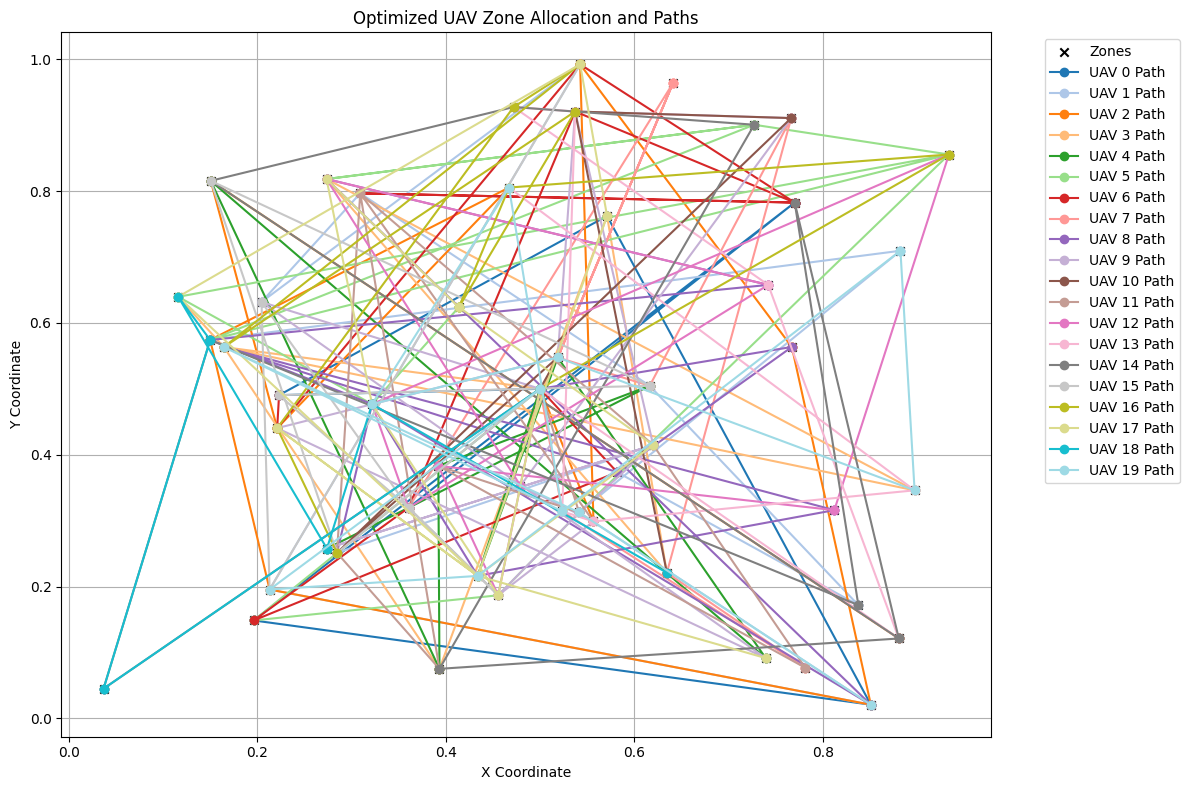


This solution uses a Genetic Algorithm to optimize zone assignments and UAV paths.
Each chromosome encodes a unique partitioning and ordering of zones to UAVs.
Fitness considers mission time, energy usage, and coverage of all zones.
Selection, crossover, and mutation iteratively improve solutions over generations,
balancing exploration and exploitation to find a near-optimal rescue swarm deployment.



In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Problem and GA parameters
NUM_ZONES = 50
NUM_UAVS = 20
POP_SIZE = 100
MAX_GENERATIONS = 200
ZONE_POS = np.random.rand(NUM_ZONES, 2)  # XY coordinates
ZONE_PRIORITY = np.random.randint(1, 11, NUM_ZONES)  # Priority score 1 to 10

def distance(a, b):
    return np.linalg.norm(a - b)

def initialize_population():
    population = []
    for _ in range(POP_SIZE):
        zone_order = np.random.permutation(NUM_ZONES)
        bounds = np.linspace(0, NUM_ZONES, NUM_UAVS + 1, dtype=int)
        allocation = [zone_order[bounds[i]:bounds[i+1]].tolist() for i in range(NUM_UAVS)]
        population.append(allocation)
    return population

def fitness(chromosome):
    max_time = 0
    total_energy = 0
    coverage = set()
    for uav_route in chromosome:
        route_len = 0
        prev_pos = np.array([0.5, 0.5])  # Start from city center
        for idx in uav_route:
            route_len += distance(prev_pos, ZONE_POS[idx])
            prev_pos = ZONE_POS[idx]
            coverage.add(idx)
        max_time = max(max_time, route_len)
        total_energy += route_len
    missed = NUM_ZONES - len(coverage)
    score = (-0.5 * max_time) + (-0.5 * total_energy) + (-5 * missed)
    return score

def select(population, fitnesses):
    idx = np.argsort(fitnesses)[-int(POP_SIZE/2):]
    return [population[i] for i in idx]

def crossover(parent1, parent2):
    child = []
    for u1, u2 in zip(parent1, parent2):
        c = random.choice([u1, u2])
        child.append(c)
    zones = [z for sub in child for z in sub]
    missing = set(range(NUM_ZONES)) - set(zones)
    for m in missing:
        random.choice(child).append(m)
    return child

def mutate(chromosome):
    a, b = random.sample(range(NUM_UAVS), 2)
    if chromosome[a] and chromosome[b]:
        za = random.choice(chromosome[a])
        zb = random.choice(chromosome[b])
        idxa = chromosome[a].index(za)
        idxb = chromosome[b].index(zb)
        chromosome[a][idxa], chromosome[b][idxb] = zb, za
    return chromosome

def genetic_algorithm():
    population = initialize_population()
    for gen in range(MAX_GENERATIONS):
        fitnesses = [fitness(chrom) for chrom in population]
        selected = select(population, fitnesses)
        next_gen = []
        while len(next_gen) < POP_SIZE:
            p1, p2 = random.sample(selected, 2)
            child = crossover(p1, p2)
            if random.random() < 0.2:
                child = mutate(child)
            next_gen.append(child)
        population = next_gen
    best_idx = np.argmax([fitness(chrom) for chrom in population])
    return population[best_idx]

best_solution = genetic_algorithm()

# Output zone allocation per UAV
for uav_id, route in enumerate(best_solution):
    print(f"UAV {uav_id}: Zones {route}")

# Calculate and print fitness score
best_score = fitness(best_solution)
print(f"\nSwarm Performance Score (Fitness): {best_score:.3f}")

# Plot the zones and UAV paths
colors = cm.get_cmap('tab20', NUM_UAVS)
plt.figure(figsize=(12, 8))
plt.scatter(ZONE_POS[:, 0], ZONE_POS[:, 1], c='black', marker='x', label='Zones')

for uav_id, route in enumerate(best_solution):
    if len(route) == 0:
        continue
    path_x = [0.5] + [ZONE_POS[idx, 0] for idx in route]
    path_y = [0.5] + [ZONE_POS[idx, 1] for idx in route]
    plt.plot(path_x, path_y, marker='o', label=f'UAV {uav_id} Path', color=colors(uav_id))
    plt.scatter(path_x[1:], path_y[1:], color=colors(uav_id))

plt.title("Optimized UAV Zone Allocation and Paths")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Explanation of method
explanation = """
This solution uses a Genetic Algorithm to optimize zone assignments and UAV paths.
Each chromosome encodes a unique partitioning and ordering of zones to UAVs.
Fitness considers mission time, energy usage, and coverage of all zones.
Selection, crossover, and mutation iteratively improve solutions over generations,
balancing exploration and exploitation to find a near-optimal rescue swarm deployment.
"""
print(explanation)